In [1]:
import cv2
import imutils
import datetime
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
video = "/home/dxyang/localdata/warp/dm-test/test_short.mp4"

## First frame delta method

In [ ]:
vc = cv2.VideoCapture(video)
frame_count = 0
first_frame = None
min_area = 500

while True:
    ret, frame = vc.read()
    if not ret:
        print("Error reading frames or end of video")
        break
    frame_count += 1
    width = frame.shape[1]
    height = frame.shape[0]
        
    # convert frames to grayscale and blur
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
    
    # initialize first frame
    if first_frame is None:
        first_frame = gray
        continue

    # compute the absolute difference between the current frame and
    # first frame
    frame_delta = cv2.absdiff(first_frame, gray)
    ret, thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)
    
    # dilate the thresholded image to fill in holes, then find contours
    # on thresholded image
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # loop over the contours
    for c in cnts:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < min_area:
            continue
        
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        text = "Occupied"
            
    # draw the text and timestamp on the frame
    cv2.putText(frame, "Room Status: {}".format(text), (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.putText(frame, datetime.datetime.now().strftime("%A %d %B %Y %I:%M:%S%p"),
        (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)

    smaller_frame = cv2.resize(frame, (width // 4, height // 4))
    smaller_thresh = cv2.resize(thresh, (width // 4, height // 4))
    smaller_frame_delta = cv2.resize(frame_delta, (width // 4, height // 4))
    
    cv2.imshow("Raw", smaller_frame)
    cv2.imshow("Thresh", smaller_thresh)
    cv2.imshow("Frame Delta", smaller_frame_delta)
    
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key is pressed, break from the lop
    if key == ord("q"):
        break
        
# cleanup the camera and close any open windows
vc.release()
cv2.destroyAllWindows()


## OpenCV BG subtractor class

In [ ]:
algo = "MOG2"
min_area = 100

if algo == 'MOG2':
    '''
    Parameters
    history
        Length of the history.
    varThreshold
        Threshold on the squared Mahalanobis distance between the pixel and the model to decide whether a pixel is well described by the background model. This parameter does not affect the background update.
    detectShadows
        If true, the algorithm will detect shadows and mark them. It decreases the speed a bit, so if you do not need this feature, set the parameter to false.
    '''
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history = 500,
        varThreshold = 200,
        detectShadows = True,
    )
else:
    bg_subtractor = cv2.createBackgroundSubtractorKNN()

vc = cv2.VideoCapture(video)
frame_count = 0

while True:
    ret, frame = vc.read()
    if frame is None:
        break
    frame_count += 1
    width = frame.shape[1]
    height = frame.shape[0]

    fg_mask = bg_subtractor.apply(frame)

    # dilate the thresholded image to fill in holes, then find contours
    # on thresholded image
    fg_mask = cv2.dilate(fg_mask, None, iterations=2)
    cnts = cv2.findContours(fg_mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # loop over the contours
    for c in cnts:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < min_area:
            continue
        
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        text = "Occupied"
            
    # draw the text and timestamp on the frame
    cv2.putText(frame, "Room Status: {}".format(text), (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.putText(frame, datetime.datetime.now().strftime("%A %d %B %Y %I:%M:%S%p"),
        (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)
    
    
    # add frame number
    cv2.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv2.putText(frame, str(vc.get(cv2.CAP_PROP_POS_FRAMES)), (15, 15),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))

    # visualize
    smaller_frame = cv2.resize(frame, (width // 4, height // 4))
    smaller_fg_mask = cv2.resize(fg_mask, (width // 4, height // 4))
    
    cv2.imshow("Frame", smaller_frame)
    cv2.imshow("Foreground", smaller_fg_mask)

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break


## Torch RAFT Dense optical Flow

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision.io import write_png
import torchvision.transforms.functional as F

from torchvision.models.optical_flow import Raft_Large_Weights
from torchvision.models.optical_flow import raft_large
from torchvision.utils import flow_to_image

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
video = "/home/dxyang/localdata/warp/dm-test/test_short.mp4"

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()
print(transforms)
model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

def preprocess(img1_batch, img2_batch, resize=True):
    img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    return transforms(img1_batch, img2_batch)

In [ ]:
flow_output = "/home/dxyang/localdata/warp/dm-test/raft-flow"
if not os.path.exists(flow_output):
    os.makedirs(flow_output)
    
vc = cv2.VideoCapture(video)
num_frames = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
frame_count = 0
pbar = tqdm(total=num_frames)

last_frame = None
while True:
    ret, frame = vc.read()
    if frame is None:
        break
    width = frame.shape[1]
    height = frame.shape[0]

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    rgb_chw_frame = np.transpose(rgb_frame, (2, 0, 1))
    batched_rgb_frame = np.expand_dims(rgb_chw_frame, axis=0)
    
    if last_frame is None:
        last_frame = batched_rgb_frame
        continue
    
    img_batch_t1 = torch.from_numpy(last_frame).to(device)
    img_batch_t2 = torch.from_numpy(batched_rgb_frame).to(device)
    resized_img_batch_t1, resized_img_batch_t2 = preprocess(img_batch_t1, img_batch_t2)

    flows = model(resized_img_batch_t1, resized_img_batch_t2)
    
#     print(f"type = {type(flows)}")
#     print(f"length = {len(flows)} = number of iterations of the model")

    predicted_flows = flows[-1]
#     print(f"dtype = {predicted_flows.dtype}")
#     print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
#     print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

    flow_img = flow_to_image(predicted_flows)[0].cpu()
#     plt.imshow(F.to_pil_image(flow_img))
    
    frame_str = str(frame_count).zfill(6)
    write_png(flow_img, f"{flow_output}/flow_{frame_str}.png")

    last_frame = batched_rgb_frame
    frame_count += 1
    pbar.update()

## OpenCV Lucas-Kankade Dense Optical Flow

In [ ]:
flow_output = "/home/dxyang/localdata/warp/dm-test/opencv-flow"
np_output = f"{flow_output}/numpy"
if not os.path.exists(flow_output):
    os.makedirs(flow_output)
if not os.path.exists(np_output):
    os.makedirs(np_output)
    
vc = cv2.VideoCapture(video)
num_frames = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))
frame_count = 0
pbar = tqdm(total=num_frames)

last_frame = None
while True:
    ret, frame = vc.read()
    if frame is None:
        break
    width = frame.shape[1]
    height = frame.shape[0]

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.resize(gray_frame, (width // 2, height // 2))

    if last_frame is None:
        last_frame = gray_frame
        continue
    
    frame_str = str(frame_count).zfill(6)
    if os.path.exists(f"{np_output}/{frame_str}.npy"):
        frame_count += 1
        pbar.update()
        continue
    
    flow = cv2.calcOpticalFlowFarneback(
        prev=last_frame, 
        next=gray_frame, 
        flow=None, 
        pyr_scale=0.5, 
        levels=3, 
        winsize=15, 
        iterations=3, 
        poly_n=5, 
        poly_sigma=1.2, 
        flags=0
    )
    chw_flow = np.transpose(flow, (2, 0, 1))    
    torch_flow = torch.from_numpy(chw_flow)
    flow_img = flow_to_image(torch_flow)

    frame_str = str(frame_count).zfill(6)
    write_png(flow_img, f"{flow_output}/flow_{frame_str}.png")
    np.save(f"{np_output}/{frame_str}.npy", chw_flow)

    last_frame = gray_frame
    frame_count += 1
    pbar.update()

## Read frames and anomaly detection optical flow

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob
from PIL import Image

In [7]:
def divergence(f):
    """
    Computes the divergence of the vector field f, corresponding to dFx/dx + dFy/dy + ...
    :param f: List of ndarrays, where every item of the list is one dimension of the vector field
    :return: Single ndarray of the same shape as each of the items in f, which corresponds to a scalar field
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], axis=i) for i in range(num_dims)])


0it [00:00, ?it/s]

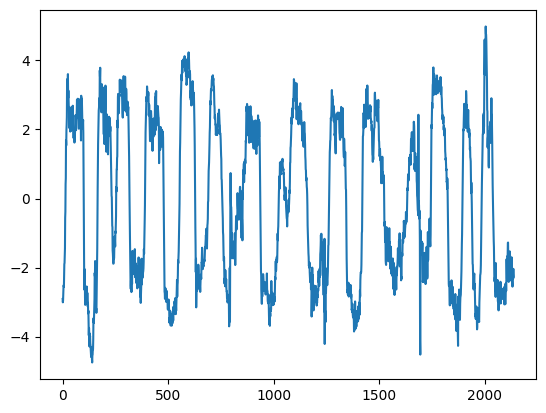

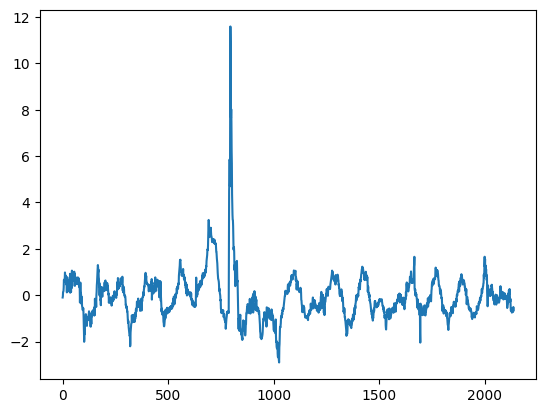

In [32]:
rgb = "/home/dxyang/localdata/warp/dm-test/rgb"
flow_output = "/home/dxyang/localdata/warp/dm-test/opencv-flow"
np_output = f"{flow_output}/numpy"
flow_np_files = glob.glob(f"{np_output}/*")
flow_np_files.sort()

dendrogyra_4k_hw = ((0, 1400), (400,2200))
dendrogyra_hd_hw = ((0, 700), (200,1100))
dendrogrya_hd_mask = np.zeros((1080, 1920))
dendrogrya_hd_mask[
    dendrogyra_hd_hw[0][0]:dendrogyra_hd_hw[0][1], 
    dendrogyra_hd_hw[1][0]:dendrogyra_hd_hw[1][1],            
] = 1.0
hd_dim_hw = (1080, 1920)

do_divergence = False
avg_divs = []
avg_divs_bg_sub = []

do_average_vector = True
avg_xs = []
avg_ys = []

plot = False

for frame_count, f in tqdm(enumerate(flow_np_files)):
    frame_str = str(frame_count).zfill(6)
    flow = np.load(f)
    if plot:
        rgb_image = np.array(Image.open(f"{rgb}/frame_{frame_str}.png"))

    height, width = flow.shape[1], flow.shape[2]
    U = flow[0]
    V = flow[1]
    
    magnitude_threshold = 2.0
    magnitudes = np.sqrt(U * U + V * V)
    mag_idxs_x, mag_idxs_y = np.where(magnitudes > magnitude_threshold)
    magnitude_mask = np.zeros_like(U)
    magnitude_mask[mag_idxs_x, mag_idxs_y] = 1.0
    final_mask = np.logical_and(dendrogrya_hd_mask, magnitude_mask)

    if plot:
        X, Y = np.meshgrid(np.arange(0, width), np.arange(height, 0, -1))
        scale = 20
        Q = plt.quiver(
            X[::scale, ::scale], 
            Y[::scale, ::scale], 
            U[::scale, ::scale], 
            V[::scale, ::scale],
            scale=200.0
        )
        ax = plt.gca()
        rect = patches.Rectangle(
            (dendrogyra_hd_hw[1][0], hd_dim_hw[0] - dendrogyra_hd_hw[0][0]), 
            dendrogyra_hd_hw[1][1] - dendrogyra_hd_hw[1][0],
            -1 * (dendrogyra_hd_hw[0][1] - dendrogyra_hd_hw[1][0]),
            linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

        plt.figure()
        plt.imshow(rgb_image)
        ax = plt.gca()
        rect = patches.Rectangle(
            (dendrogyra_4k_hw[1][0], dendrogyra_4k_hw[0][0]), 
            dendrogyra_4k_hw[1][1] - dendrogyra_4k_hw[1][0],
            dendrogyra_4k_hw[0][1] - dendrogyra_4k_hw[1][0],
            linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()
        
        plt.hist(np.ravel(magnitudes))
        plt.show()
        plt.hist(np.ravel(magnitudes[mag_idxs_x, mag_idxs_y]))
        plt.show()
    
    F = [flow[0], flow[1]]
    
    
    if plot:
        plt.figure()
        plt.imshow(div, cmap='hot')
        plt.colorbar()
        
        plt.figure()
        plt.imshow(dendrogrya_hd_mask)
        
        plt.figure()
        plt.imshow(magnitude_mask)
    
    if do_divergence:
        avg_flow_x = np.mean(flow[0])
        avg_flow_y = np.mean(flow[1])
        F_bg_sub = [flow[0] - avg_flow_x, flow[1] - avg_flow_y]

        div = divergence(F)
        div_bg_sub = divergence(F_bg_sub)

        average_divergence = np.mean(div[final_mask])
        average_divergence_bg_sub = np.mean(div_bg_sub[final_mask])
        avg_divs.append(average_divergence)
        avg_divs_bg_sub.append(average_divergence_bg_sub)
    
    if do_average_vector:
        vecs_x = F[0][final_mask]
        vecs_y = F[1][final_mask]
        
        average_x = np.mean(vecs_x)
        average_y = np.mean(vecs_y)
        
        avg_xs.append(average_x)
        avg_ys.append(average_y)
    
    if plot:
        break

if do_divergence:
    plt.figure()
    plt.plot(avg_divs)
    plt.figure()
    plt.plot(avg_divs_bg_sub)

if do_average_vector:
    plt.figure()
    plt.plot(avg_xs)
    plt.figure()
    plt.plot(avg_ys)

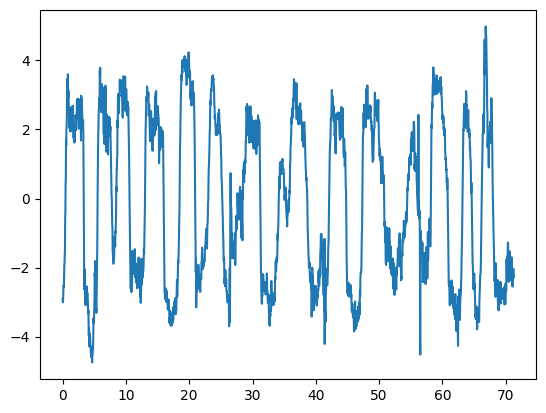

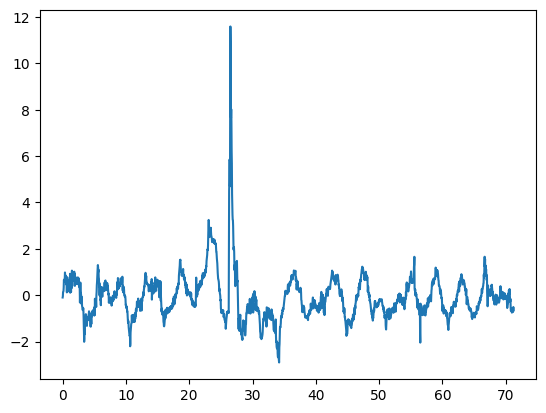

In [35]:
plt.figure()
plt.plot([i/30.0 for i in range(len(avg_xs))], avg_xs)
plt.figure()
plt.plot([i/30.0 for i in range(len(avg_ys))], avg_ys)

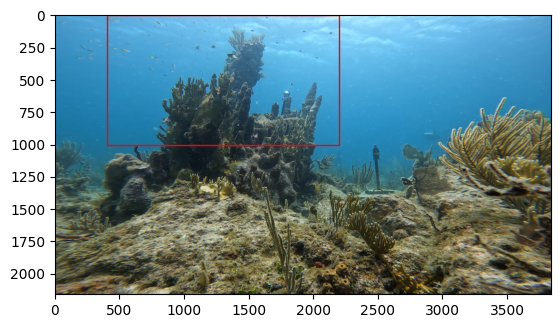

In [33]:
rgb_image = np.array(Image.open(f"{rgb}/frame_{frame_str}.png"))
plt.figure()
plt.imshow(rgb_image)
ax = plt.gca()
rect = patches.Rectangle(
    (dendrogyra_4k_hw[1][0], dendrogyra_4k_hw[0][0]), 
    dendrogyra_4k_hw[1][1] - dendrogyra_4k_hw[1][0],
    dendrogyra_4k_hw[0][1] - dendrogyra_4k_hw[1][0],
    linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()


  0%|          | 0/75348 [00:00<?, ?it/s]

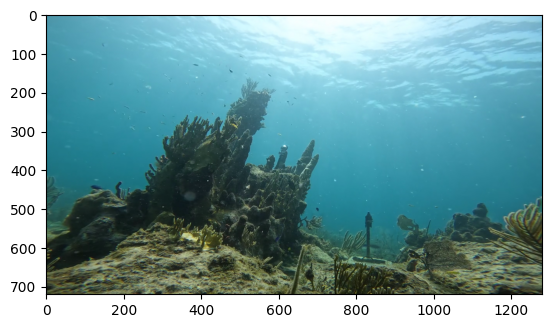

In [44]:
video = "/data/vision/fisher/expres2/dxyang/warp/dm-dataset/2023-07-03/2023-07-03-GoPro2-DM-concat-720p.mp4"
vc = cv2.VideoCapture(video)
num_frames = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))

for frame_num in tqdm(range(num_frames)):
    ret, frame = vc.read()
    if not ret:
        print("Error reading frames or end of video")
        break
    
    width = frame.shape[1]
    height = frame.shape[0]
    if frame_num == 10_000:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_frame)
        break

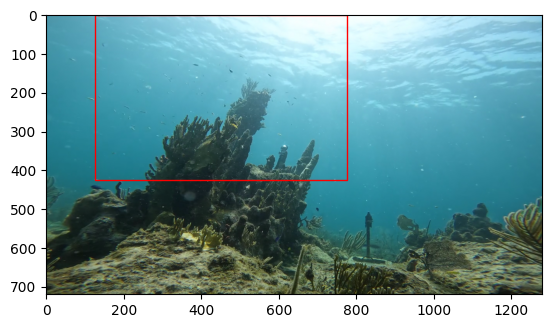

In [62]:
plt.imshow(rgb_frame)
ax = plt.gca()
x, y, w, h = 125, 0, 650, 425
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()


  0%|          | 0/109989 [00:00<?, ?it/s]

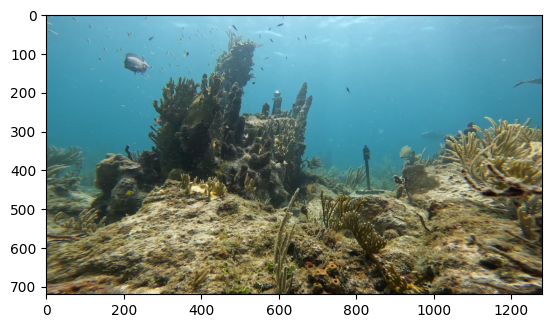

In [63]:
video = "/data/vision/fisher/expres2/dxyang/warp/dm-dataset/2023-07-03/2023-07-03-GoPro3-DM-concat-720p.mp4"
vc = cv2.VideoCapture(video)
num_frames = int(vc.get(cv2.CAP_PROP_FRAME_COUNT))

for frame_num in tqdm(range(num_frames)):
    ret, frame = vc.read()
    if not ret:
        print("Error reading frames or end of video")
        break
    
    width = frame.shape[1]
    height = frame.shape[0]
    if frame_num == 10_000:
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_frame)
        break

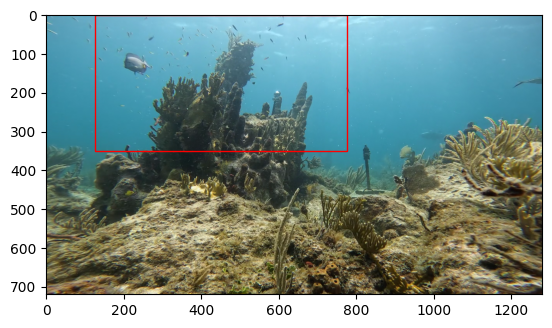

In [65]:
plt.imshow(rgb_frame)
ax = plt.gca()
x, y, w, h = 125, 0, 650, 350
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()
